In [1]:
import tensorflow as tf
print(tf.__version__)

2025-02-17 15:17:13.088904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.1


In [ ]:
import subprocess
from rpy2.robjects import r
from rc_data_class import RcData
from rc_folds_class  import rcFolds
from rc_pred_ann_model import PredAnnModel
from rc_individual_fold import RcFoldForANN
import numpy as np
import random
import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle

# Genetic Algorithm Parameters
POP_SIZE = 100      # Population size
N_GENERATIONS = 50   # Number of generations
TOURNAMENT_SIZE = 3  # Tournament selection (k=3)
CROSSOVER_RATE = 0.8 # Probability of crossover
MUTATION_RATE = 0.05 # Mutation probability per gene
ELITE_PERCENTAGE = 0.05 # Top 5% preserved

#Other parameters
p_value = 0.2
split_train = True
folds = 5
num_epochs = 700
dna_dict = {}  # Empty dictionary

# making a data frame to keep track of GA progress
column_names = [f'auc_{i+1}' for i in range(POP_SIZE)]
# Initialize an empty DataFrame with columns
ga_df = pd.DataFrame(columns=column_names)


def get_genes_list(p_thresh, split_train):
    # Define the R script path
    r_script = "rc_get_diff_genes.r"
    
    # Build the command to run the R script
    command = ["Rscript", r_script, str(p_thresh), str(split_train)]
    
    result = subprocess.run(command, capture_output=True, text=True)
    
    # Check if the R script ran successfully
    if result.returncode == 0:
        print("R script executed successfully.")
    
        # Read the generated file
        rds_path = '/tmp/work/RCproject_code/sean_ann_python/ann_gene_set.rds'
        current_genes = r.readRDS(rds_path)
        print(len(current_genes))
        
    else:
        print("Error in R script execution:")
        print(result.stderr)

    return(current_genes.tolist())

def generate_individual():
    """Creates a binary chromosome for feature selection."""
    return [random.randint(0, 1) for _ in range(len(current_genes))]

def evaluate_fitness(individual,gene_list,input_data,count):
    """Evaluates the fitness of an individual based on the average test auc value across folds."""
    # selected_features = [s for s, m in zip(gene_list, individual) if m]  #application of a binary mask to the genes list
    individual = np.array(individual, dtype=bool)  # Ensure it's a boolean array
    gene_list = np.array(gene_list)  # Convert to NumPy array if it's a list
    selected_features = gene_list[individual]
    
    if len(selected_features) == 0:
        return 0  # Prevent division by zero when no features are selected
    current_aucs = []
    current_folds = rcFolds(input_data,folds)
    for i in range(folds):
            current_fold = RcFoldForANN(current_folds,i)
            fold_count = i + 1
            current_member = count + 1
            print(f"Currently training, population member {current_member}, with fold {fold_count}.")
            current_model = PredAnnModel(current_fold,current_genes, num_epochs = num_epochs)
            test_auc_list = current_model.test_auc_list
            current_auc = max(test_auc_list)
            current_aucs.append(current_auc)
    score = np.mean(current_aucs)
    return score  # Higher auc average = better fitness

def tournament_selection(population, fitness_scores):
    """Selects a parent using tournament selection (k=3)."""
    competitors = random.sample(list(enumerate(fitness_scores)), TOURNAMENT_SIZE)
    best = max(competitors, key=lambda x: x[1])  # Select individual with best fitness
    return population[best[0]]


def uniform_crossover(parent1, parent2):
    """Performs uniform crossover (each gene has 50% chance of swapping)."""
    if random.random() < CROSSOVER_RATE:
        SWAP_PROBABILITY = 0.2
        child1 = [p1 if random.random() > SWAP_PROBABILITY else p2 for p1, p2 in zip(parent1, parent2)]
        child2 = [p2 if random.random() > SWAP_PROBABILITY else p1 for p1, p2 in zip(parent1, parent2)]
        return child1, child2
    return parent1[:], parent2[:]  # No crossover, children are copies

def mutate(individual):
    """Mutates an individual by flipping bits with a small probability."""
    return [1 - gene if random.random() < MUTATION_RATE else gene for gene in individual]

def plot_row_averages(df):
    """
    Plots the average of each row in the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing numerical values.
    """
    row_averages = df.mean(axis=1)  # Compute the average across each row
    
    plt.figure(figsize=(10, 5))
    plt.plot(row_averages, marker='o', linestyle='-', color='b', label='Row Averages')
    
    plt.xlabel("Generation")
    plt.ylabel("Average AUC Values")
    plt.title("Average of Each Row in DataFrame")
    plt.legend()
    plt.grid(True)
    
    plt.show()


# establish the dataset object
current_data = RcData()

# grab the intial feature set
current_genes = get_genes_list(p_value, split_train)

# making a data frame to keep track of GA progress
column_names = [f'auc_{i+1}' for i in range(POP_SIZE)]

# Initialize an empty DataFrame with columns
ga_df = pd.DataFrame(columns=column_names)

# Initialize population
population = [generate_individual() for _ in range(POP_SIZE)]
dna_dict[1] = population

# Evaluate initial fitness

fitness_scores = [evaluate_fitness(ind, current_genes, current_data, count) for count, ind in enumerate(population)]

best_fitness = max(fitness_scores)
print(f"Generation {1}, Best Accuracy: {best_fitness:.4f}")

ga_df.loc[len(ga_df)] = fitness_scores

for gen in range(N_GENERATIONS):
    # Select the top individuals (elitism)
    elite_count = int(ELITE_PERCENTAGE * POP_SIZE)
    elites = [population[i] for i in np.argsort(fitness_scores)[-elite_count:]]  # Keep best individuals

    # Generate next generation
    new_population = elites[:]  # Start with elites

    while len(new_population) < POP_SIZE:
        # Select parents using tournament selection
        parent1 = tournament_selection(population, fitness_scores)
        parent2 = tournament_selection(population, fitness_scores)

        # Crossover to generate children
        child1, child2 = uniform_crossover(parent1, parent2)

        # Apply mutation
        child1 = mutate(child1)
        child2 = mutate(child2)

        # Add to new population (ensure we don't exceed population size)
        new_population.append(child1)
        if len(new_population) < POP_SIZE:
            new_population.append(child2)

    # Update population and fitness scores
    population = new_population
    current_generation = gen + 2
    dna_dict[current_generation] = new_population
    fitness_scores = [evaluate_fitness(ind, current_genes, current_data, count) for count, ind in enumerate(population)]
    ga_df.loc[len(ga_df)] = fitness_scores

    pickle.dump(dna_dict, open("dna_dict.pkl", "wb"))
    ga_df.to_pickle("ga_df.pkl")

    # Print best result every 10 generations
    if gen % 1 == 0:
        best_fitness = max(fitness_scores)
        print(f"Generation {current_generation}, Best Accuracy: {best_fitness:.4f}")

Data successfully loaded.
R script executed successfully.
2061
Currently training, population member 1, with fold 1.
Epoch 0, Average Outcome Loss: 0.8833919962247213, Average Accuracy: 0.5, Test AUC: 0.5000, Test Accuracy: 0.6622
Epoch 100, Average Outcome Loss: 1.1995150645573933, Average Accuracy: 0.5, Test AUC: 0.4335, Test Accuracy: 0.3378
Epoch 200, Average Outcome Loss: 0.5753614472018348, Average Accuracy: 0.7361111111111112, Test AUC: 0.6727, Test Accuracy: 0.5811
Epoch 300, Average Outcome Loss: 3.604563554128011, Average Accuracy: 0.5, Test AUC: 0.6212, Test Accuracy: 0.6622
Epoch 400, Average Outcome Loss: 0.7112525171703763, Average Accuracy: 0.5, Test AUC: 0.5045, Test Accuracy: 0.3378
Epoch 500, Average Outcome Loss: 0.6806660029623244, Average Accuracy: 0.5, Test AUC: 0.6653, Test Accuracy: 0.6081
Epoch 600, Average Outcome Loss: 0.7455459833145142, Average Accuracy: 0.6319444444444444, Test AUC: 0.6702, Test Accuracy: 0.7162
Currently training, population member 1, wit

In [6]:
# Load the df back
loaded_df = pd.read_pickle("ga_df.pkl")
# Load the dictionary to select the sequences of interest
dna_dict = pickle.load(open("dna_dict.pkl", "rb"))

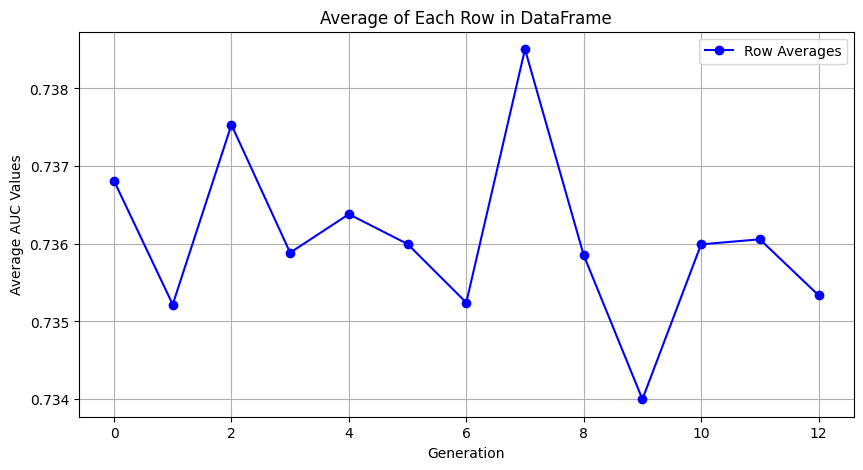

In [7]:
plot_row_averages(loaded_df)

In [8]:
loaded_df

,auc_1,auc_2,auc_3,auc_4,auc_5,auc_6,auc_7,auc_8,auc_9,auc_10,...,auc_41,auc_42,auc_43,auc_44,auc_45,auc_46,auc_47,auc_48,auc_49,auc_50
0,0.746495,0.746229,0.754107,0.737837,0.739340,0.726863,0.732239,0.736472,0.744917,0.708656,...,0.744492,0.734340,0.740737,0.738019,0.754106,0.735998,0.708663,0.755688,0.737142,0.727634
1,0.741354,0.710287,0.701228,0.759920,0.735949,0.727726,0.711074,0.719348,0.699121,0.746878,...,0.751990,0.728328,0.725434,0.740482,0.724447,0.749106,0.743200,0.748562,0.725650,0.726084
2,0.730004,0.755823,0.723138,0.752937,0.749285,0.735545,0.745446,0.753285,0.750353,0.713870,...,0.737464,0.738118,0.726832,0.738185,0.747772,0.733479,0.738025,0.739875,0.745766,0.755319
3,0.740872,0.698425,0.753876,0.728627,0.732903,0.731335,0.743179,0.721552,0.743744,0.739257,...,0.742276,0.745581,0.745272,0.733541,0.713230,0.747104,0.734238,0.752046,0.730808,0.728304
4,0.732596,0.741419,0.700319,0.715004,0.730546,0.758471,0.739422,0.722367,0.755346,0.738099,...,0.741828,0.740173,0.733899,0.737092,0.748031,0.738120,0.726513,0.756979,0.734026,0.738391
5,0.740361,0.731202,0.727234,0.731880,0.725403,0.730125,0.725843,0.726705,0.747513,0.724536,...,0.740099,0.744293,0.730783,0.730743,0.743072,0.722949,0.730817,0.745100,0.750092,0.724210
6,0.750698,0.740151,0.713864,0.715702,0.719773,0.731079,0.720075,0.756173,0.733781,0.720044,...,0.703606,0.734226,0.760466,0.751208,0.739302,0.746298,0.744342,0.731138,0.734395,0.738478
7,0.746243,0.739789,0.725051,0.759190,0.730823,0.712938,0.752342,0.751036,0.727212,0.732852,...,0.737419,0.746778,0.741980,0.737725,0.743488,0.722853,0.724981,0.735269,0.758277,0.758542
8,0.746265,0.749314,0.732116,0.751580,0.733612,0.719914,0.722286,0.727938,0.757834,0.732184,...,0.732481,0.736050,0.747435,0.740714,0.745783,0.737013,0.744870,0.717942,0.734116,0.726567
9,0.745325,0.724680,0.739713,0.726951,0.742621,0.733599,0.714669,0.742842,0.736045,0.731124,...,0.739608,0.735847,0.772285,0.709163,0.729417,0.746323,0.713095,0.746608,0.748883,0.711781


In [ ]:
print('test')